# Data Cartography for Multi-class Classification

Goals:
1. Subclass `Trainer` and overwrite to save out `ids`, `logits`, `gold_label` for each example after each training step.
2. Use plotting utilities from Data Cartography repo to generate plots

In [64]:
!pip install --upgrade transformers torch datasets evaluate accelerate peft ipywidgets scikit-learn matplotlib seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 6.5 MB/s eta 0:00:00a 0:00:01


## Load, explore, and prepare data

In [1]:
from datasets import load_dataset

dataset = load_dataset("lmsys/toxic-chat")

In [2]:
dataset = dataset.rename_columns({"user_input": "text", "toxicity": "label"})

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['conv_id', 'text', 'model_output', 'human_annotation', 'label', 'jailbreaking', 'openai_moderation'],
        num_rows: 5082
    })
    test: Dataset({
        features: ['conv_id', 'text', 'model_output', 'human_annotation', 'label', 'jailbreaking', 'openai_moderation'],
        num_rows: 5083
    })
})

In [4]:
dataset["train"][0]

{'conv_id': 'e0c9b3e05414814485dbdcb9a29334d502e59803af9c26df03e9d1de5e7afe67',
 'text': 'Masturbacja jest proces co oitrzebuje',
 'model_output': 'Masturbacja to proces, który może pozytywnie wpłynąć na zdrowie psychiczne i fizyczne człowieka, ponieważ pomaga w relaksie, redukuje stres i pomaga w uśpieniu. Może też być używana jako dodatkowa form',
 'human_annotation': True,
 'label': 0,
 'jailbreaking': 0.0,
 'openai_moderation': "[['sexual', 0.16727015376091003], ['hate', 0.0014814797323197126], ['violence', 7.014749280642718e-05], ['self-harm', 5.5694090406177565e-06], ['sexual/minors', 4.127006832277402e-06], ['violence/graphic', 5.00143471526826e-07], ['hate/threatening', 2.3769071155754773e-09]]"}

#### Let's see if/how many examples will be truncated

In [5]:
from transformers import AutoTokenizer

model_id = "distilbert-base-uncased"
# model_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [6]:
def check_seq_length(dataset, tokenizer):
    """Check to see how many samples are longer than max seq length"""

    print("----Number samples longer than model's context length----")

    dataset = dataset.map(
        lambda examples: {"num_tokens": len(tokenizer(examples["text"])["input_ids"])}
    )

    for split in ["test", "train"]:
        df = dataset["train"].to_pandas()
        count = len(df.loc[df["num_tokens"] >= tokenizer.model_max_length])

        print(f"{split.upper()}: {count}")

In [7]:
check_seq_length(dataset, tokenizer)

----Number samples longer than model's context length----
TEST: 15
TRAIN: 15


#### Now preprocess the data

In [8]:
# First lets add a unique _numeric_ id to each example (required for tensors)
def add_id(example, idx):
    example["id"] = idx
    return example


# Apply the function to each example in the dataset
dataset = dataset.map(add_id, with_indices=True)

In [9]:
def preprocess_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
    )


tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/5082 [00:00<?, ? examples/s]

Map:   0%|          | 0/5083 [00:00<?, ? examples/s]

In [10]:
tokenized_dataset = tokenized_dataset.remove_columns(
    [
        "conv_id",
        "text",
        "model_output",
        "human_annotation",
        "jailbreaking",
        "openai_moderation",
    ]
)

In [11]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'id', 'input_ids', 'attention_mask'],
        num_rows: 5082
    })
    test: Dataset({
        features: ['label', 'id', 'input_ids', 'attention_mask'],
        num_rows: 5083
    })
})

## Train a baseline model

In [12]:
from transformers import (
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)

model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
import numpy as np
from evaluate import load

f1_metric = load("f1")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_metric.compute(predictions=predictions, references=labels)["f1"]

    return {"f1": f1}

In [14]:
training_args = TrainingArguments(
    output_dir="toxicity_baseline",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
    save_total_limit=3,
    seed=42,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,0.198100,0.125564,0.650000
2,0.094400,0.128091,0.704225
3,0.053200,0.136714,0.708709
4,0.032400,0.149886,0.721264
5,0.022100,0.158985,0.715134


TrainOutput(global_step=795, training_loss=0.08006221063481937, metrics={'train_runtime': 262.3008, 'train_samples_per_second': 96.874, 'train_steps_per_second': 3.031, 'total_flos': 2085120164420376.0, 'train_loss': 0.08006221063481937, 'epoch': 5.0})

In [15]:
trainer.evaluate(tokenized_dataset["test"])

{'eval_loss': 0.14988568425178528,
 'eval_f1': 0.721264367816092,
 'eval_runtime': 12.4968,
 'eval_samples_per_second': 406.743,
 'eval_steps_per_second': 12.723,
 'epoch': 5.0}

In [18]:
# trainer.model.save_pretrained("toxicity_baseline_model")

In [28]:
?TrainingArguments

Init signature:
TrainingArguments(
    output_dir: str,
    overwrite_output_dir: bool = False,
    do_train: bool = False,
    do_eval: bool = False,
    do_predict: bool = False,
    evaluation_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no',
    prediction_loss_only: bool = False,
    per_device_train_batch_size: int = 8,
    per_device_eval_batch_size: int = 8,
    per_gpu_train_batch_size: Optional[int] = None,
    per_gpu_eval_batch_size: Optional[int] = None,
    gradient_accumulation_steps: int = 1,
    eval_accumulation_steps: Optional[int] = None,
    eval_delay: Optional[float] = 0,
    learning_rate: float = 5e-05,
    weight_decay: float = 0.0,
    adam_beta1: float = 0.9,
    adam_beta2: float = 0.999,
    adam_epsilon: float = 1e-08,
    max_grad_norm: float = 1.0,
    num_train_epochs: float = 3.0,
    max_steps: int = -1,
    lr_scheduler_type: Union[transformers.trainer_utils.SchedulerType, str] = 'linear',
    lr_scheduler_kwargs: Optional[Di

## Setup `Trainer` for data cartography

In [16]:
class IdDataCollatorWithPadding(DataCollatorWithPadding):
    """Data collator that removes "id" col from features for padding, then adds it back"""

    def __call__(self, features):
        # remove "id" col from features for padding
        if "id" in features[0]:
            ids = [feature.pop("id") for feature in features]

        # use parent class method for padding
        batch = super().__call__(features)

        # add "id" col back to features
        batch["id"] = ids

        return batch

In [17]:
id_data_collator = IdDataCollatorWithPadding(tokenizer=tokenizer)

In [18]:
import os
import json
from pathlib import Path
from peft import PeftModel
from transformers.modeling_utils import unwrap_model
from transformers.models.auto.modeling_auto import MODEL_FOR_CAUSAL_LM_MAPPING_NAMES
from transformers.utils import is_peft_available


def _is_peft_model(model):
    return is_peft_available() and isinstance(model, PeftModel)


class DataCartographyTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        """
        How the loss is computed by Trainer. By default, all models return the loss in the first element.

        Subclass and override for custom behavior.
        """
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None

        outputs = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            labels=inputs["labels"],
        )

        # Save data cartography outputs
        if model.training:
            if "id" in inputs:
                ids_out = inputs["id"]

            logits_out = outputs["logits"].detach().cpu().tolist()
            labels_out = inputs["labels"].detach().cpu().tolist()

            current_epoch = int(self.state.epoch)

            directory = Path(self.args.output_dir) / "training_dynamics"
            os.makedirs(directory, exist_ok=True)
            filename = directory / f"dynamics_epoch_{current_epoch}.jsonl"

            with open(filename, "a") as f:
                for id, logit, label in zip(ids_out, logits_out, labels_out):
                    data_dict = {
                        "guid": id,
                        f"logits_epoch_{current_epoch}": logit,
                        "gold": label,
                    }
                    json_line = json.dumps(data_dict)
                    f.write(json_line + "\n")

        # Save past state if it exists
        # TODO: this needs to be fixed and made cleaner later.
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            unwrapped_model = unwrap_model(model)
            if _is_peft_model(unwrapped_model):
                model_name = unwrapped_model.base_model.model._get_name()
            else:
                model_name = unwrapped_model._get_name()
            if model_name in MODEL_FOR_CAUSAL_LM_MAPPING_NAMES.values():
                loss = self.label_smoother(outputs, labels, shift_labels=True)
            else:
                loss = self.label_smoother(outputs, labels)
        else:
            if isinstance(outputs, dict) and "loss" not in outputs:
                raise ValueError(
                    "The model did not return a loss from the inputs, only the following keys: "
                    f"{','.join(outputs.keys())}. For reference, the inputs it received are {','.join(inputs.keys())}."
                )
            # We don't use .loss here since the model may return tuples instead of ModelOutput.
            loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]

        return (loss, outputs) if return_outputs else loss

In [20]:
training_args = TrainingArguments(
    output_dir="dc_trainer_baseline",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
    save_total_limit=3,
    seed=42,
    remove_unused_columns=False,
)

dc_trainer = DataCartographyTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=id_data_collator,
    compute_metrics=compute_metrics,
)

dc_trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.014300,0.264849,0.680240
2,0.008300,0.260923,0.709285
3,0.008000,0.258801,0.681638
4,0.004200,0.254551,0.712610
5,0.003500,0.262041,0.712813


TrainOutput(global_step=795, training_loss=0.0076538937646637925, metrics={'train_runtime': 262.821, 'train_samples_per_second': 96.682, 'train_steps_per_second': 3.025, 'total_flos': 2085120164420376.0, 'train_loss': 0.0076538937646637925, 'epoch': 5.0})

In [ ]:
dc_trainer.evaluate(tokenized_dataset["test"])

## Calculate and visualize data cartography metrics

In [6]:
!git clone https://github.com/allenai/cartography.git
!mv cartography cartography_repo
!cp -r cartography_repo/cartography .
!rm -rf cartography_repo

Cloning into 'cartography'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 158 (delta 38), reused 38 (delta 38), pack-reused 110
Receiving objects: 100% (158/158), 29.03 MiB | 38.31 MiB/s, done.
Resolving deltas: 100% (80/80), done.


In [68]:
dc_trainer.args.output_dir

'dc_trainer_baseline'

In [10]:
import sys

sys.path.append(os.path.join(os.getcwd(), "cartography"))

In [33]:
import os
from dataclasses import dataclass

from cartography.selection.selection_utils import read_training_dynamics
from cartography.selection.train_dy_filtering import (
    compute_train_dy_metrics,
    plot_data_map,
)


@dataclass
class Args:
    model_dir: str
    model: str
    task_name: str = "binary-classification"
    burn_out: int = 100
    include_ci: bool = True

    def __post_init__(self):
        self.plots_dir = os.path.join(self.model_dir, "plots")


def compute_and_plot_cartography_metrics(args):
    """
    Helper function to compute cartography metrics.

    Adapted from: https://github.com/allenai/cartography/blob/3df3438fcc7324e706dee2e787426389bbd8fb1a/cartography/selection/train_dy_filtering.py#L396-L423

    Note - filtering logic was left out.
    """
    # gather and calculate metrics
    training_dynamics = read_training_dynamics(
        f"./{args.model_dir}",
        strip_last=False,
        id_field="guid",
        burn_out=args.burn_out if args.burn_out < 100 else None,
    )

    total_epochs = len(list(training_dynamics.values())[0]["logits"])

    if args.burn_out > total_epochs:
        args.burn_out = total_epochs

    train_dy_metrics, _ = compute_train_dy_metrics(training_dynamics, args)

    burn_out_str = f"_{args.burn_out}" if args.burn_out > total_epochs else ""
    train_dy_filename = os.path.join(args.model_dir, f"td_metrics{burn_out_str}.jsonl")
    train_dy_metrics.to_json(train_dy_filename, orient="records", lines=True)

    # generate plots
    if not os.path.exists(args.plots_dir):
        os.makedirs(args.plots_dir, exist_ok=True)

    plot_data_map(
        train_dy_metrics,
        args.plots_dir,
        title=args.task_name,
        show_hist=True,
        model=args.model,
    )

    print("Plots saved to: ", args.plots_dir)

    return train_dy_metrics

2024-01-14 23:08:30,434 - INFO - cartography.selection.selection_utils - Reading 5 files from ././dc_trainer_baseline/training_dynamics ...
100%|██████████| 5/5 [00:00<00:00, 51.07it/s]
2024-01-14 23:08:30,533 - INFO - cartography.selection.selection_utils - Read training dynamics for 5082 train instances.
2024-01-14 23:08:30,534 - INFO - cartography.selection.train_dy_filtering - Computing training dynamics across 5 epochs
2024-01-14 23:08:30,535 - INFO - cartography.selection.train_dy_filtering - Metrics computed: confidence, variability, correctness, forgetfulness, threshold_closeness
100%|██████████| 5082/5082 [00:00<00:00, 5564.08it/s]
2024-01-14 23:08:31,479 - INFO - cartography.selection.train_dy_filtering - Plotting figure for binary-classification using the distilbert-base-uncased model ...
2024-01-14 23:08:31,575 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numb

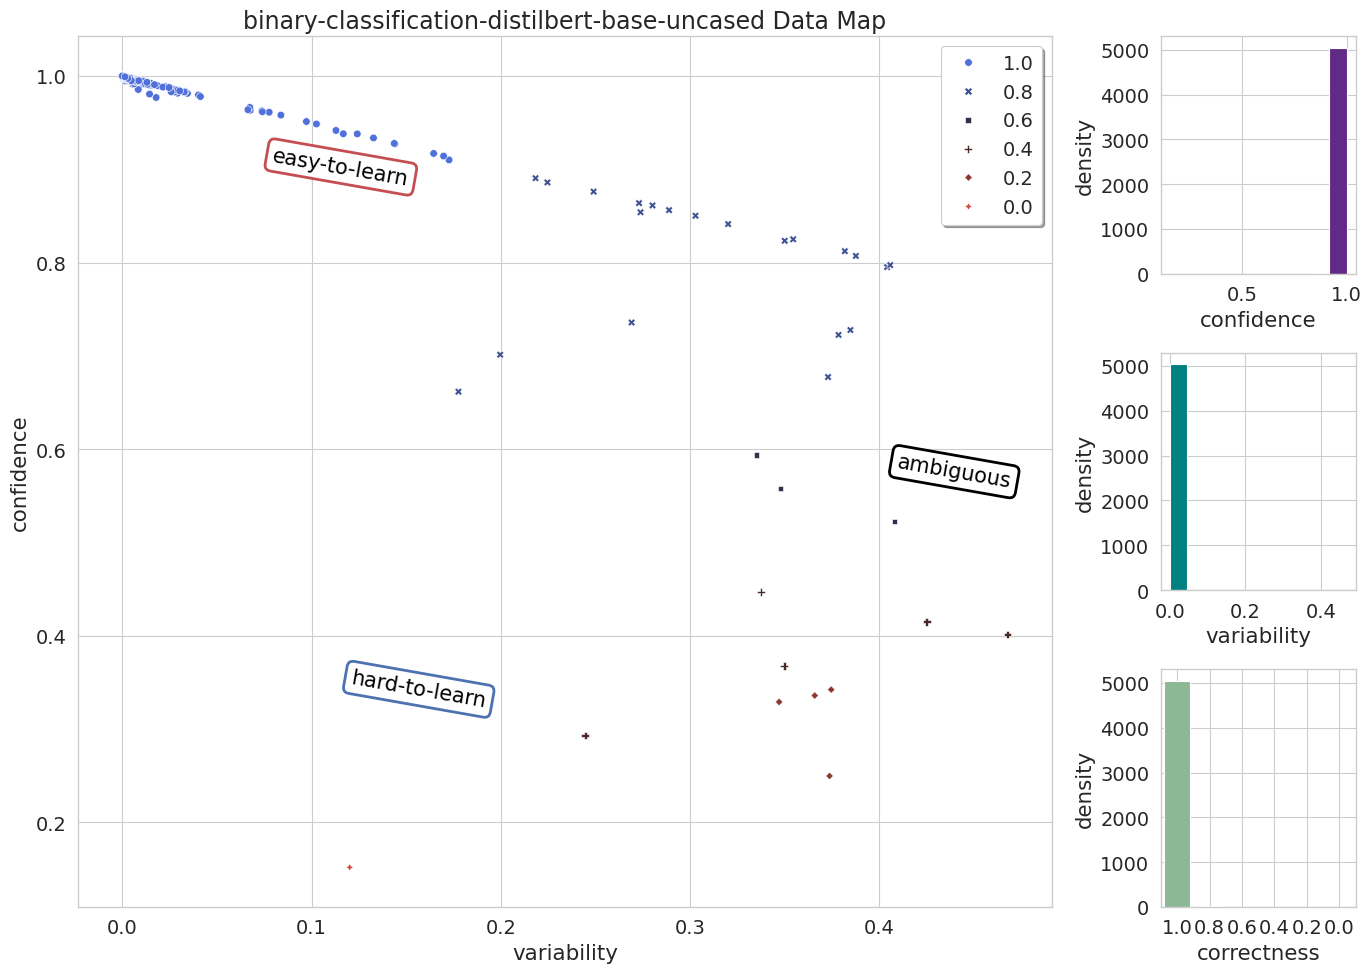

In [36]:
args = Args(
    model_dir="./dc_trainer_baseline",
    model="distilbert-base-uncased",
)
metrics = compute_and_plot_cartography_metrics(args)

In [37]:
metrics

,guid,index,threshold_closeness,confidence,variability,correctness,forgetfulness
0,3844,0,0.000201,0.999799,0.000299,5,0
1,1022,1,0.000194,0.999806,0.000227,5,0
2,3353,2,0.000171,0.999828,0.000145,5,0
3,1711,3,0.000251,0.999749,0.000273,5,0
4,3928,4,0.000193,0.999807,0.000265,5,0
...,...,...,...,...,...,...,...
5077,900,5077,0.000084,0.999916,0.000049,5,0
5078,3848,5078,0.000094,0.999906,0.000074,5,0
5079,2181,5079,0.058236,0.937909,0.124182,5,0
5080,410,5080,0.000102,0.999898,0.000056,5,0
